In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

plt.style.use('fivethirtyeight') 

import re

import json
import csv



In [2]:
with open('train.json', encoding="utf8") as f:
    train_data = json.load(f)
with open('additional_data/zalo/zalo_question.json', encoding="utf8") as f:
    train_zalo_data = json.load(f)
with open('public_test.json', encoding="utf8") as f:
    test_data = json.load(f) 
with open('additional_data/ALQAC_2022_training_data/law.json', encoding="utf8") as f:
    law_alqac_2022_data = json.load(f)
with open('additional_data/zalo/zalo_corpus.json', encoding="utf8") as f:
    law_zalo_data = json.load(f)
with open('law.json', encoding="utf8") as f:
    law_original_data = json.load(f)


## Thống kê số lượng

In [3]:
def quantityStatistics(src):
    # Get the number of overall entities
    num_overall_entities = len(src)
    print("Số lượng bộ luật tổng thể:", num_overall_entities)
    print()

    # Get the number of entities in each entity
    for entity in src:
        entity_id = entity['id']
        num_entities = len(entity['articles'])
        print("Số lượng", entity_id, ":", num_entities)


#### Original Law File

In [4]:
quantityStatistics(law_original_data)

Số lượng bộ luật tổng thể: 17

Số lượng Luật Phòng, chống ma túy : 55
Số lượng Luật Bảo vệ môi trường : 171
Số lượng Luật Viên chức : 62
Số lượng Luật Cư trú : 38
Số lượng Luật Tiếp cận thông tin : 37
Số lượng Luật Trồng trọt : 83
Số lượng Luật An ninh mạng : 43
Số lượng Luật Chăn nuôi : 83
Số lượng Hiến pháp : 0
Số lượng Luật Du lịch : 78
Số lượng Luật Tố tụng hành chính : 372
Số lượng Luật Hôn nhân và gia đình : 133
Số lượng Bộ luật dân sự : 689
Số lượng Luật Điện ảnh : 50
Số lượng Luật Trọng tài thương mại : 81
Số lượng Luật Thanh niên : 41
Số lượng Luật Giáo dục : 115


#### ALQAC 2022 Law File

In [5]:
quantityStatistics(law_alqac_2022_data)

Số lượng bộ luật tổng thể: 4

Số lượng 91/2015/QH13 : 689
Số lượng 24/2018/QH14 : 43
Số lượng 45/2019/QH14 : 220
Số lượng 01/VBHN-VPQH : 425


#### Zalo Law File

In [6]:
# quantityStatistics(law_zalo_data) (dài quá =)) 

## Thống kê độ dài

In [7]:
# for entity in law_original_data:
#     entity_id = entity['id']
#     for article in entity['articles']:
#         article_id = article['id']
#         article_text = article['text']
#         text_size = len(article_text)
#         print("Size of 'text' part in Entity ID:", entity_id, ", Article ID:", article_id, ":", text_size)

In [8]:
def lengthStatistics(src):
    results = []

    for entity in src:
        entity_id = entity['id']
        max_len = float('-inf')
        min_len = float('inf')
        sum_len = 0
        total_law = len(entity['articles'])
        max_id = 0
        min_id = 0
        
        for article in entity['articles']:
            article_id = article['id']
            article_text = article['text']
            text_size = len(article_text)
            sum_len += text_size
            if text_size > max_len:
                max_len = text_size
                max_id = article_id
            if text_size < min_len:
                min_len = text_size
                min_id = article_id

        if total_law != 0:
            avg_len = sum_len / total_law 

        results.append({'Entity ID': entity_id, 'Max length': max_len, 'Max ID': max_id,'Min length': min_len, 'Min ID': min_id, 'Average length': avg_len})

    df = pd.DataFrame(results)
    return df

In [9]:
def lengthDistribution(src):
    # Create a list to store the text lengths for each entity ID
    lengths = []

    # Iterate over the entities and articles to collect the text lengths
    for entity in src:
        entity_id = entity['id']
        articles = entity['articles']
        for article in articles:
            article_text = article['text']
            text_length = len(article_text)
            lengths.append({'Entity ID': entity_id, 'Text Length': text_length})

    # Create a DataFrame from the lengths list
    df = pd.DataFrame(lengths)

    # Create a histogram for each Entity ID
    unique_ids = df['Entity ID'].unique()
    num_plots = len(unique_ids)
    num_cols = 2  # Number of columns in the subplot grid
    num_rows = (num_plots + num_cols - 1) // num_cols  # Calculate the number of rows

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_plots))  # Adjust figure size

    # Iterate over unique Entity IDs and plot histograms
    for idx, entity_id in enumerate(unique_ids):
        row = idx // num_cols
        col = idx % num_cols
        entity_data = df[df['Entity ID'] == entity_id]['Text Length']
        axs[row, col].hist(entity_data, bins=100, alpha=0.5)  # Adjust alpha for transparency
        axs[row, col].set_title(f'Entity ID: {entity_id}')
        axs[row, col].set_xlabel('Text Length')
        axs[row, col].set_ylabel('Frequency')

    plt.tight_layout()  # Adjust spacing between subplots

    # Show the plot
    plt.show()


In [44]:
def lengthAllStatistics(src):
    
    results = []

    for entity in src:
        entity_id = entity['id']
     
        for article in entity['articles']:
            article_id = article['id']
            article_text = article['text']
            text_size = len(article_text)
            results.append({'Entity ID': entity_id, 'Article ID': article_id, 'Text Size': text_size})


    df = pd.DataFrame(results)
    return df

In [45]:
def getOverallInfo(df):
     # Calculate average text size
    average_size = df['Text Size'].mean()

    # Find the entity with the biggest text size
    max_size_entity = df.loc[df['Text Size'].idxmax()]

    # Find the entity with the smallest text size
    min_size_entity = df.loc[df['Text Size'].idxmin()]

    print("Average Text Size:", average_size)
    print()
    print("Entity dài nhất:")
    print(max_size_entity)
    print()
    print("Entity ngắn nhất:")
    print(min_size_entity)

In [55]:
def lengthHistogramStatistics(df):
    # Set the bin size for the histogram
    bin_size = 100

    # Plot the histogram
    plt.hist(df['Text Size'], bins=bin_size)

    # Set the labels and title of the plot
    plt.xlabel('Text Length')
    plt.ylabel('Frequency')
    plt.title('Histogram of Text Length')

    # Display the plot
    plt.show()

In [52]:
test22 = lengthAllStatistics(law_original_data)
test22

,Entity ID,Article ID,Text Size
0,"Luật Phòng, chống ma túy",1,264
1,"Luật Phòng, chống ma túy",2,2453
2,"Luật Phòng, chống ma túy",3,1759
3,"Luật Phòng, chống ma túy",4,242
4,"Luật Phòng, chống ma túy",5,1945
...,...,...,...
2126,Luật Giáo dục,111,693
2127,Luật Giáo dục,112,1310
2128,Luật Giáo dục,113,1797
2129,Luật Giáo dục,114,329


In [48]:
getOverallInfo(test22)

Average Text Size: 854.1088690755514

Entity dài nhất:
Entity ID     Luật Bảo vệ môi trường
Article ID                         3
Text Size                       7573
Name: 57, dtype: object

Entity ngắn nhất:
Entity ID     Luật Giáo dục
Article ID                2
Text Size                17
Name: 2017, dtype: object


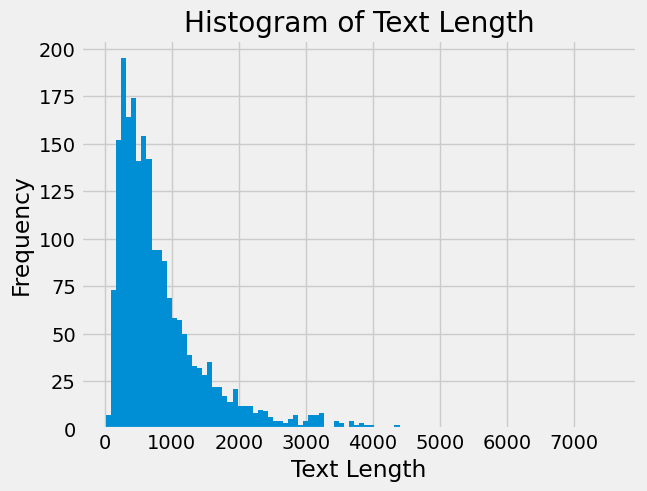

In [49]:
lengthHistogramStatistics(test22)

Average Text Size: 1298.4353764753764

Entity dài nhất:
Entity ID     12/2017/qh14
Article ID               1
Text Size           252881
Name: 17161, dtype: object

Entity ngắn nhất:
Entity ID     01/2013/ttlt-bnv-bqp
Article ID                      12
Text Size                        0
Name: 309, dtype: object


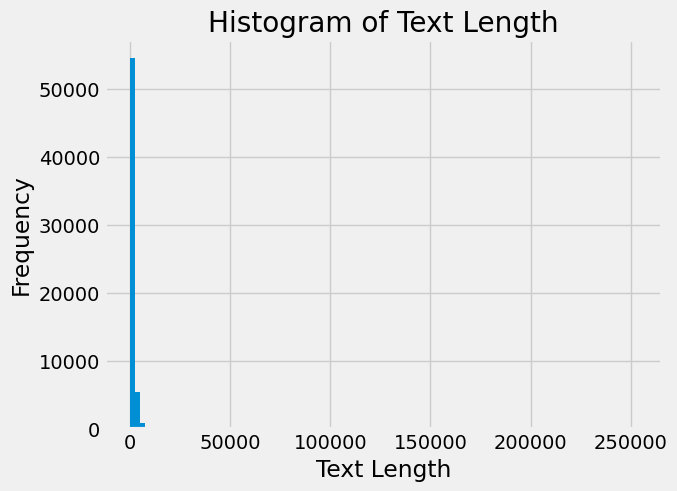

In [56]:
testzalo = lengthAllStatistics(law_zalo_data)
getOverallInfo(testzalo)
lengthHistogramStatistics(testzalo)

Average Text Size: 841.2360203340595

Entity dài nhất:
Entity ID     45/2019/QH14
Article ID             219
Text Size             7278
Name: 950, dtype: object

Entity ngắn nhất:
Entity ID     91/2015/QH13
Article ID             118
Text Size               29
Name: 117, dtype: object


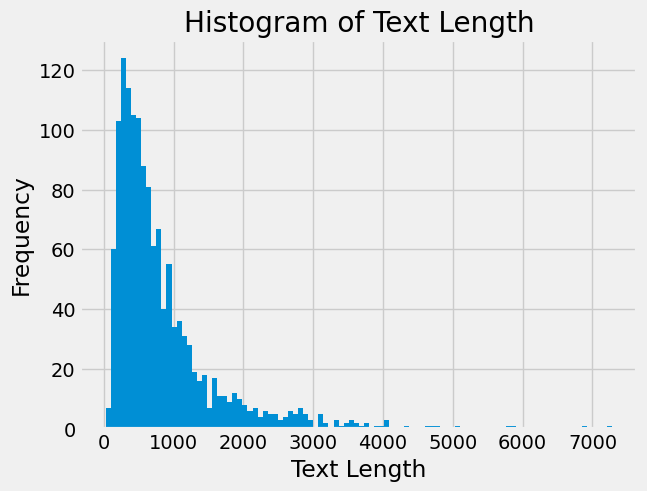

In [51]:
testalqac = lengthAllStatistics(law_alqac_2022_data)
getOverallInfo(testalqac)
lengthHistogramStatistics(testalqac)

#### Original Law File

In [10]:
law_df = lengthStatistics(law_original_data)
law_df

,Entity ID,Max length,Max ID,Min length,Min ID,Average length
0,"Luật Phòng, chống ma túy",3596.0,34,166.0,50,1023.781818
1,Luật Bảo vệ môi trường,7573.0,3,198.0,1,1750.251462
2,Luật Viên chức,3477.0,29,31.0,39,727.193548
3,Luật Cư trú,5301.0,21,203.0,14,1293.447368
4,Luật Tiếp cận thông tin,3711.0,17,197.0,10,997.297297
5,Luật Trồng trọt,3869.0,2,155.0,1,949.578313
6,Luật An ninh mạng,4362.0,17,187.0,1,1447.302326
7,Luật Chăn nuôi,5499.0,2,158.0,1,998.855422
8,Hiến pháp,-inf,0,inf,0,998.855422
9,Luật Du lịch,3073.0,37,168.0,77,966.564103


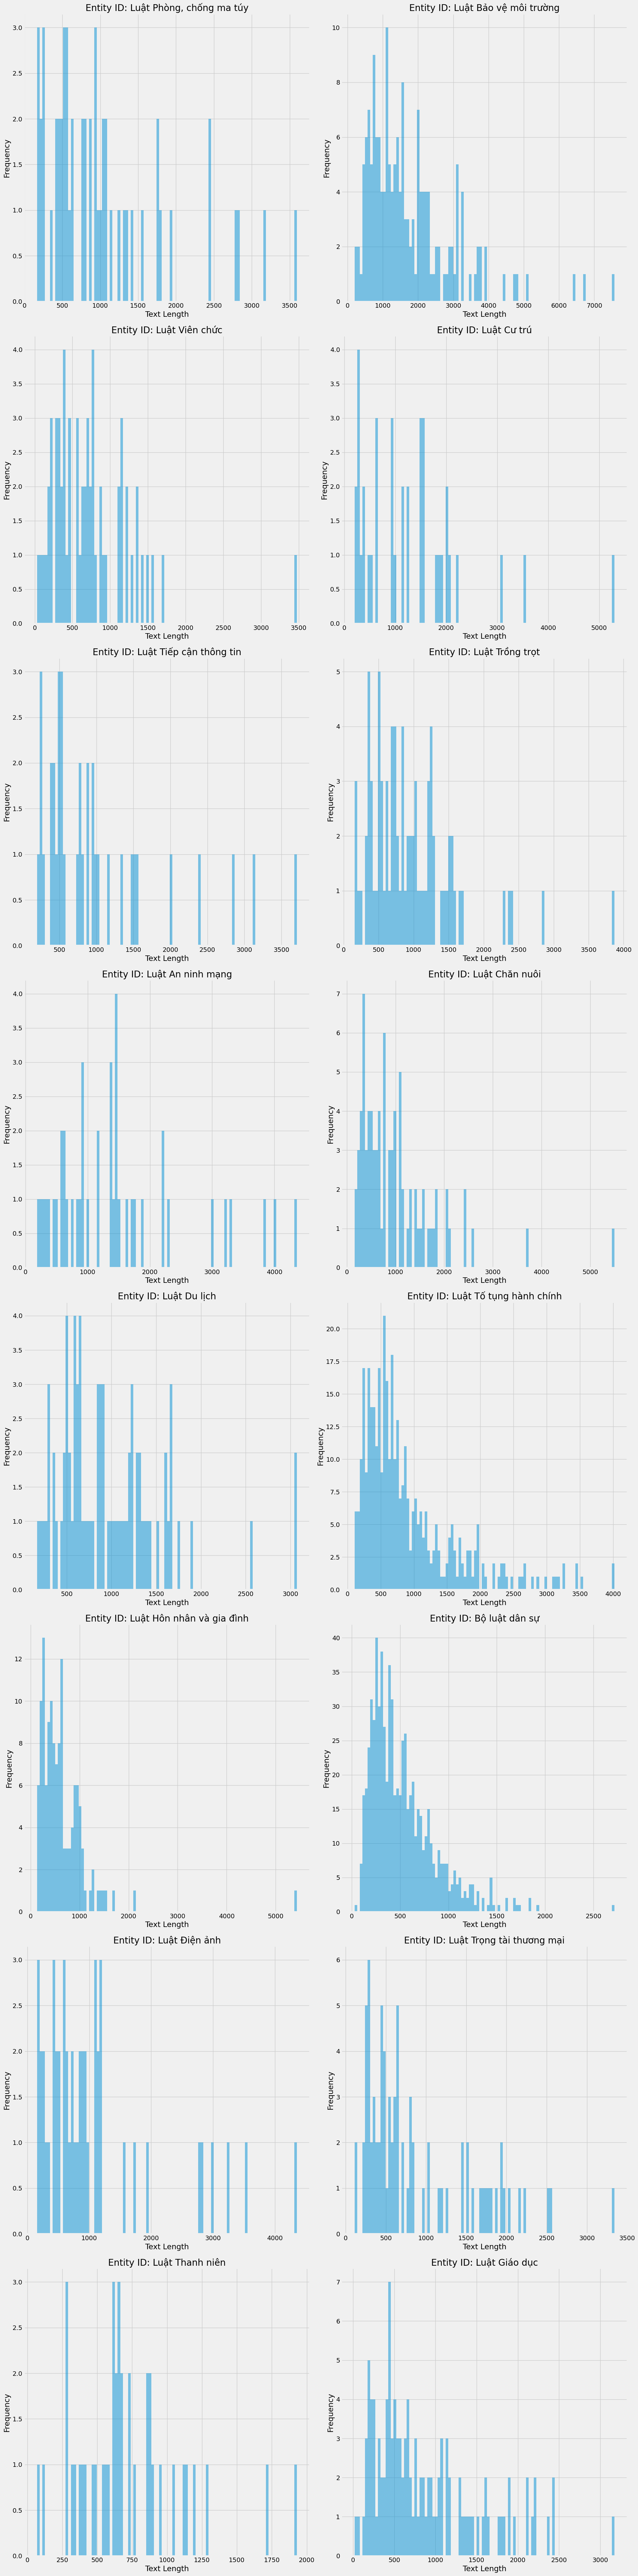

In [11]:
lengthDistribution(law_original_data)

#### ALQAC 2022 Law File

In [12]:
alqac_2022_df = lengthStatistics(law_alqac_2022_data)
alqac_2022_df

,Entity ID,Max length,Max ID,Min length,Min ID,Average length
0,91/2015/QH13,2679,683,29,118,522.346880
1,24/2018/QH14,4338,17,187,1,1437.906977
2,45/2019/QH14,7278,219,92,106,844.454545
3,01/VBHN-VPQH,6877,232,137,34,1296.176471


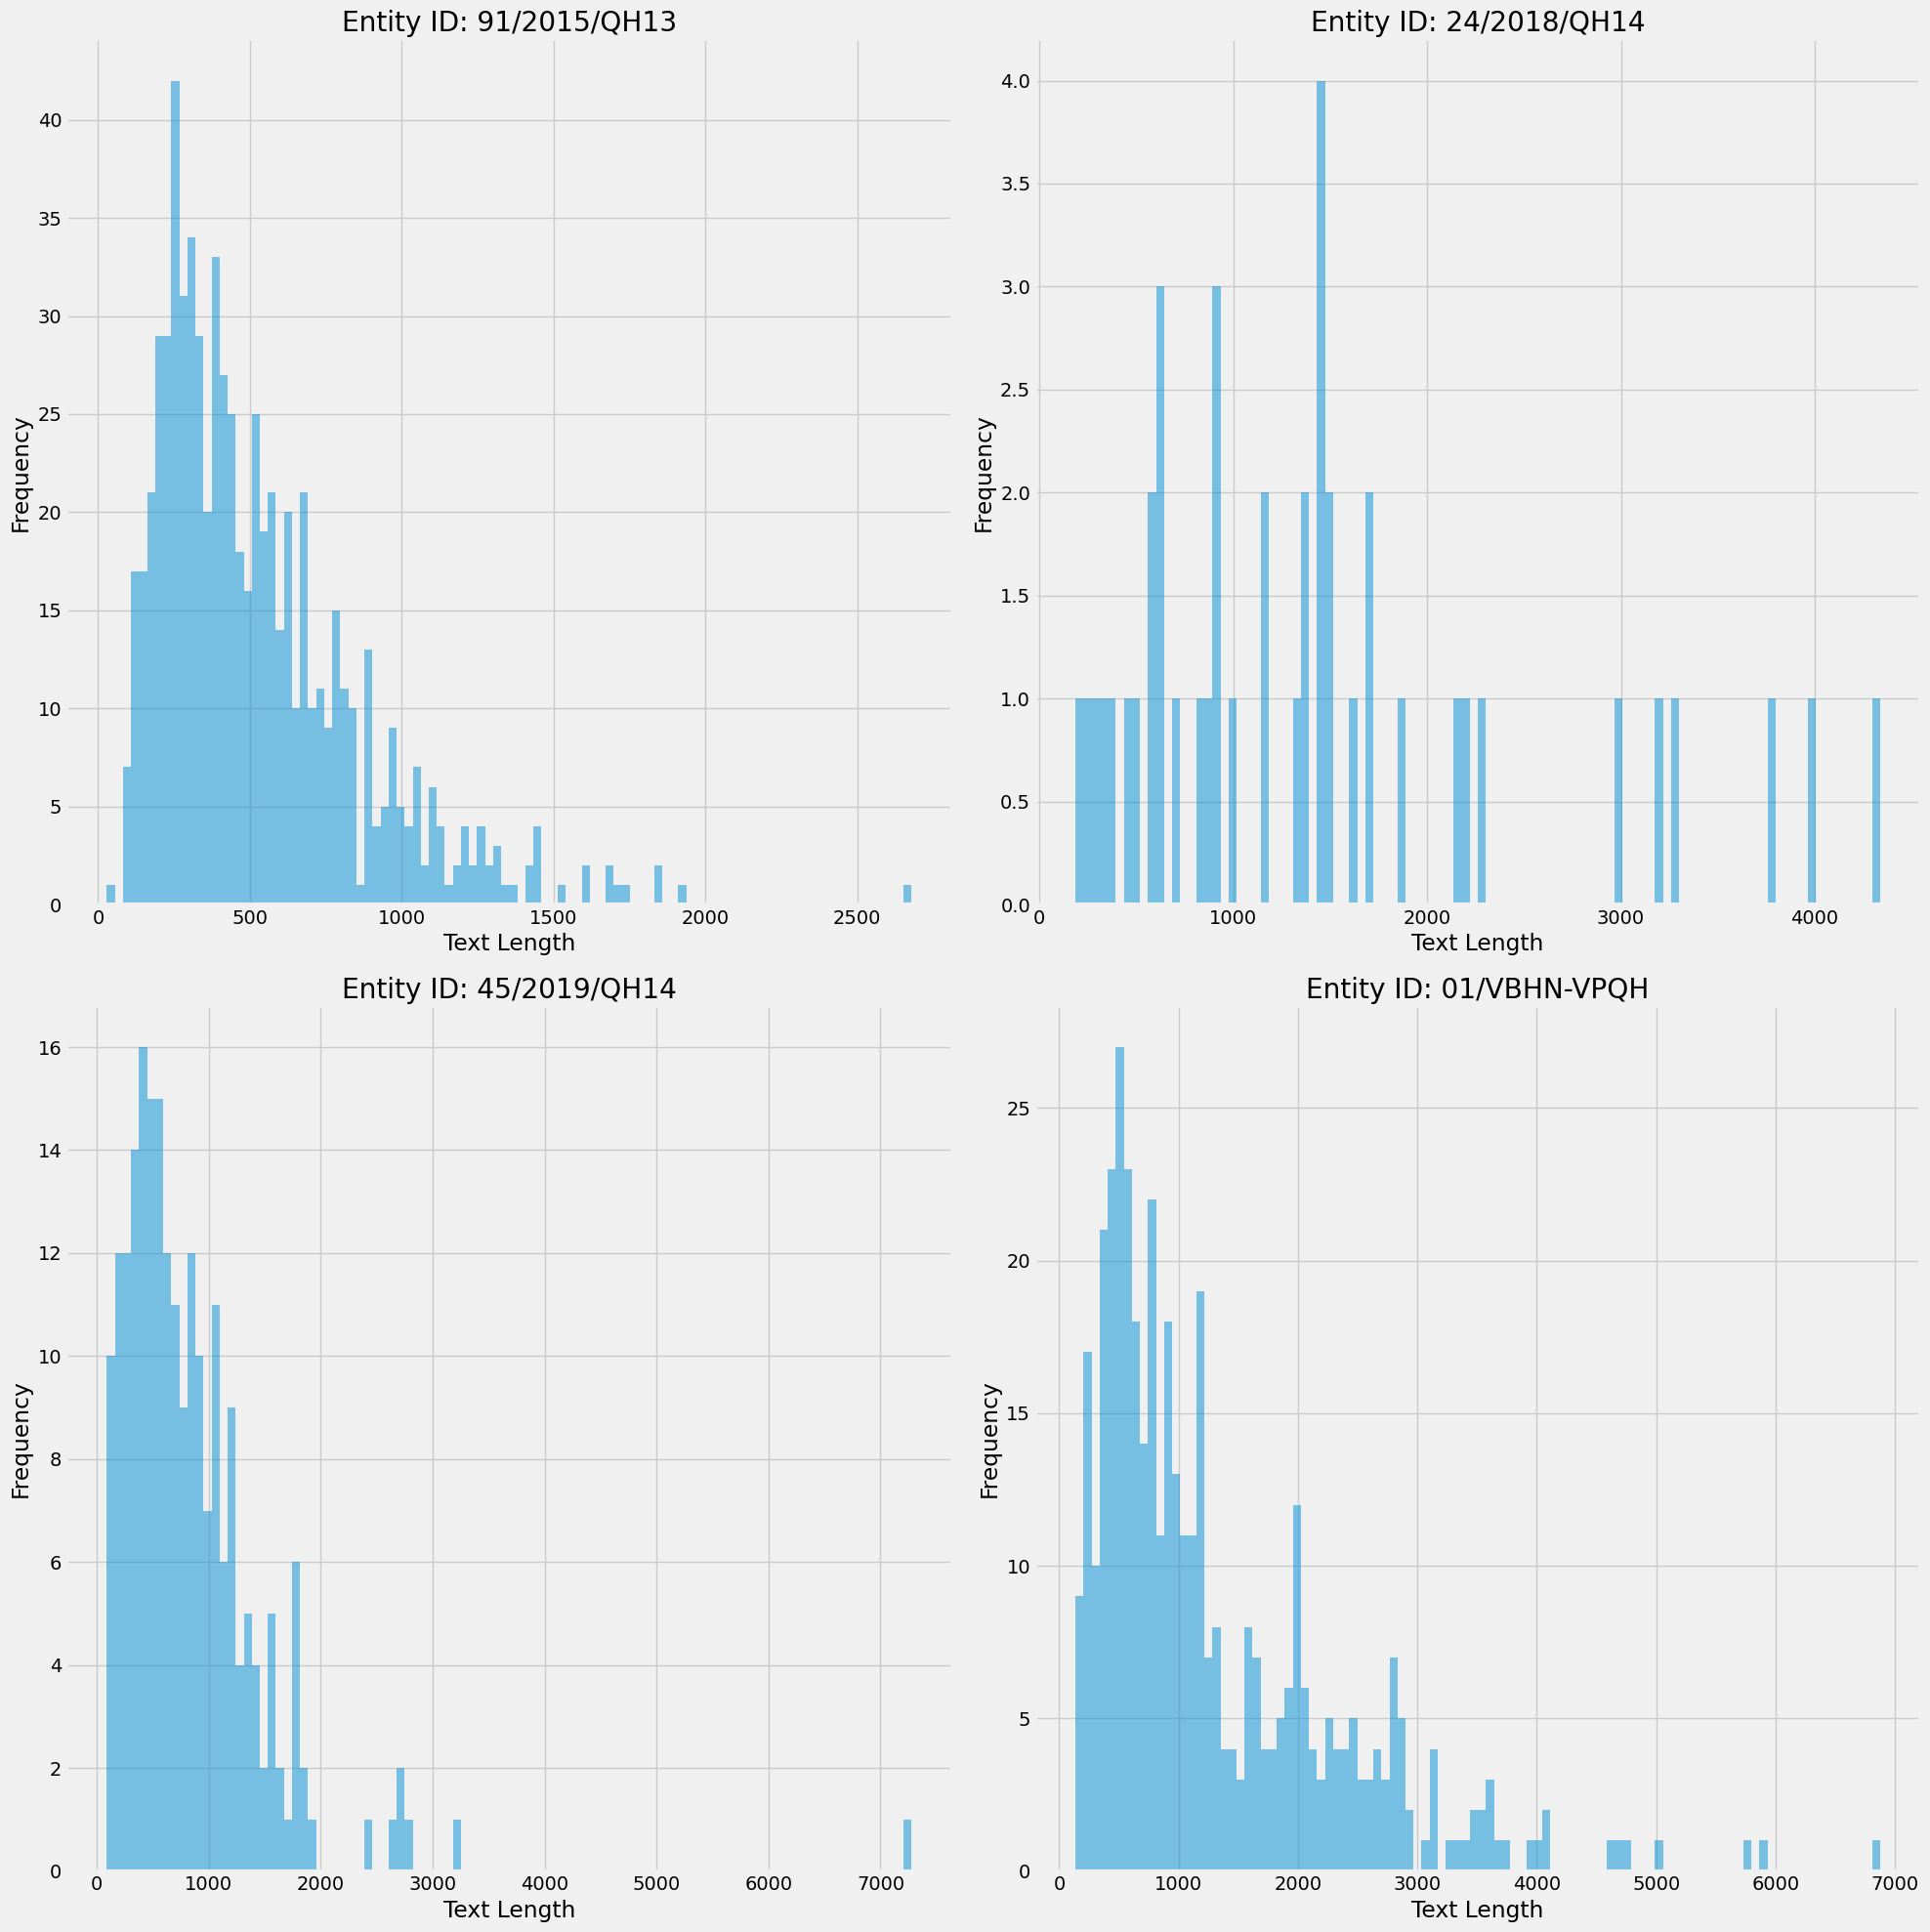

In [13]:
lengthDistribution(law_alqac_2022_data)

#### Zalo Law File

In [14]:
zalo_df = lengthStatistics(law_zalo_data)
zalo_df

,Entity ID,Max length,Max ID,Min length,Min ID,Average length
0,01/2009/tt-bnn,3019,6,163,1,905.176471
1,01/2010/tt-bng,2962,17,210,6,992.500000
2,01/2010/tt-byt,1941,9,107,16,692.294118
3,01/2011/qh13,3572,2,154,41,814.146341
4,01/2011/tt-bca,3716,9,195,5,956.944444
...,...,...,...,...,...,...
3266,99/2017/nđ-cp,5023,2,653,4,2032.000000
3267,99/2017/tt-bqp,4090,3,65,38,912.263158
3268,99/2019/nđ-cp,10820,7,317,6,2829.631579
3269,99/2019/tt-bqp,5454,3,272,19,1311.550000


In [15]:
# lengthDistribution(law_zalo_data) (dài quá =)) 

In [16]:
data2 = train_data
law_data2 = law_original_data
data3 = train_zalo_data
law_data3 = law_zalo_data

df2 = pd.DataFrame(columns=["question_id", "question", "law", "article_id", "article_segment_id", "article_segment", "article_text", "relevant"])

for obj in data2:
    question = obj["text"]
    law = obj["relevant_articles"][0]["law_id"]
    question_id = obj["question_id"]
    article_id = obj["relevant_articles"][0]["article_id"]
    
    article_segment_id = 0

    article_segment = min(len(question), 512)
    
    article_text = ""
    for law_obj in law_data2:
        if law_obj["id"] == law:
            for article in law_obj["articles"]:
                if article["id"] == article_id:
                    article_text = article["text"]
                    break

    relevant = 1
    
    row = [question_id, question, law, article_id, article_segment_id, article_segment, article_text, relevant]
    df2 = df2.append(pd.Series(row, index=df2.columns), ignore_index=True)


for obj in data3:
    question = obj["text"]
    law = obj["relevant_articles"][0]["law_id"]
    question_id = obj["id"]
    article_id = obj["relevant_articles"][0]["article_id"]
    
    article_segment_id = 0

    article_segment = min(len(question), 512)
    
    article_text = ""
    for law_obj in law_zalo_data:
        if law_obj["id"] == law:
            for article in law_obj["articles"]:
                if article["id"] == article_id:
                    article_text = article["text"]
                    break

    relevant = 1
    
    row = [question_id, question, law, article_id, article_segment_id, article_segment, article_text, relevant]
    df2 = df2.append(pd.Series(row, index=df2.columns), ignore_index=True)

df2

,question_id,question,law,article_id,article_segment_id,article_segment,article_text,relevant
0,DS-1,Người nghiện ma túy từ đủ 18 tuổi trở lên bị á...,"Luật Phòng, chống ma túy",32,0,276,Đối tượng bị áp dụng biện pháp xử lý hành chín...,1
1,DS-2,Quan hệ hôn nhân và gia đình có yếu tố nước ng...,Luật Hôn nhân và gia đình,3,0,181,"Giải thích từ ngữ\nTrong Luật này, các từ ngữ ...",1
2,DS-3,Trường hợp thông tin trong Sổ hộ khẩu còn hiệu...,Luật Cư trú,38,0,179,Điều khoản thi hành\n\n1. Luật này có hiệu lực...,1
3,DS-4,"Theo Luật Du Lịch, hợp đồng lữ hành không cần ...",Luật Du lịch,39,0,88,Hợp đồng lữ hành\n\n1. Hợp đồng lữ hành là sự ...,1
4,DS-5,"""Trọng tại thương mại"" là phương thức giải quy...",Luật Trọng tài thương mại,3,0,144,"Giải thích từ ngữ\n\nTrong Luật này, các từ ng...",1
...,...,...,...,...,...,...,...,...
3291,bd2f979dabdf0033a00ff488b2893e12,Nội dung kiểm tra công tác nghiệm thu công trì...,06/2021/nđ-cp,24,0,107,1. Công trình xây dựng phải được cơ quan nhà n...,1
3292,b7347919f2bd65a2da6f9d0b1728a51c,Mức phạt đối với hành vi chuyển mục đích sử dụ...,35/2019/nđ-cp,12,0,152,Hành vi chuyển mục đích sử dụng rừng sang mục ...,1
3293,bda416f28b8c88ce25604a26b01081cb,Trích xuất theo thi hành án hình sự được hiểu ...,41/2019/qh14,3,0,54,"Trong Luật này, các từ ngữ dưới đây được hiểu ...",1
3294,6088765b2e502c7d900a3f9a2f82f2b4,"Chạy ô tô để dầu, nhờn rơi xuống đường phạt ba...",100/2019/nđ-cp,20,0,54,1. Phạt tiền từ 100.000 đồng đến 200.000 đồng ...,1


In [17]:
filtered_df = df2[df2['article_segment'] > 512]
num_cell =  filtered_df.size
num_cell

0

In [18]:
# # Export the dataframe to a CSV file
# df2.to_csv('hmu.csv', encoding='utf-8-sig', index=False)